In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.metrics import accuracy_score
from skimage import feature

In [2]:
def load_dataset(path, classes):
    class_images = []
    
    for cls in classes :
        cls_imgs = []
        img_names = os.listdir(path + cls + "/")
        for img_name in img_names :
            cls_imgs.append(cv2.resize(cv2.imread(path + cls + "/" + img_name), (300, 200)))
        class_images.append(np.array(cls_imgs))
    return class_images

In [3]:
data = load_dataset("./Data/Training/", ["Bikes", "Horses"])

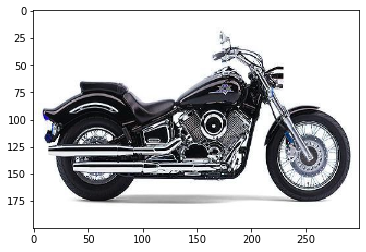

In [4]:
sample_img = data[0][1]
plt.imshow(sample_img)

#### Canny edge detection
http://aishack.in/tutorials/canny-edge-detector/

http://aishack.in/tutorials/implementing-canny-edges-scratch/

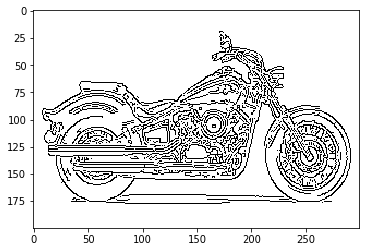

In [5]:
gray = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY) 
edged = cv2.Canny(gray, 50, 150) 
plt.imshow(edged, cmap="binary")

#### Contour detection
http://www.robindavid.fr/opencv-tutorial/chapter5-line-edge-and-contours-detection.html

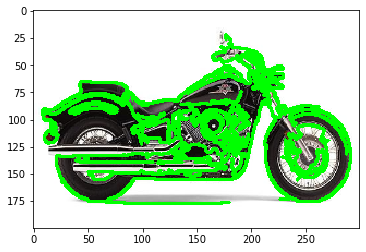

In [6]:
image, contours, hierarchy = cv2.findContours(edged,  
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
copy = sample_img.copy()
contours = sorted(contours, reverse = True, key = cv2.contourArea)[:10]
cv2.drawContours(copy, contours, -1, (0, 255, 0), 2)
plt.imshow(copy[:, :, [2, 1, 0]])

#### Segmentation
Thresholding - https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html

To segment into multiple classes, apply kmeans on pixel intensity values to find centers for different segments. Classify each pixel as the segment whose center is closest to the pixel intensity.


Also look into textures and texture classification - https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/

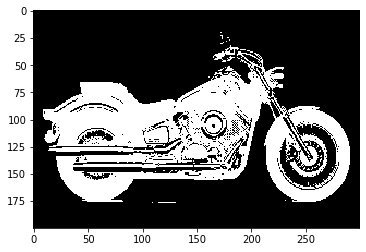

In [7]:
thresholded = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(thresholded[1], cmap = "binary")

### HOG 
https://medium.com/analytics-vidhya/a-take-on-h-o-g-feature-descriptor-e839ebba1e52

In [8]:
from scipy import signal
import scipy.misc
 
def s_x(img):
    kernel = np.array([[-1, 0, 1]])
    imgx = signal.convolve2d(img, kernel, boundary='symm', mode='same')
    return imgx
def s_y(img):
    kernel = np.array([[-1, 0, 1]]).T
    imgy = signal.convolve2d(img, kernel, boundary='symm', mode='same')
    return imgy

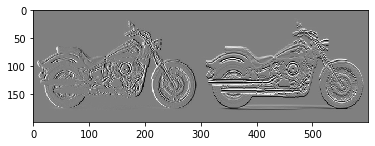

In [9]:
sample_x = s_x(gray)
sample_y = s_y(gray)
plt.imshow(np.concatenate([sample_x, sample_y], axis = 1), cmap="gray")

G_x, G_y - gradients in x, y direction respectively

|G| = sqrt(G_X^2 + G_y^2)

theta = arctan(G_x, G_y)

Divide theta into bins. These are the bina in the histogram and each pixel contributes a weight to a bin. This weight is the value of |G| at each pixel.

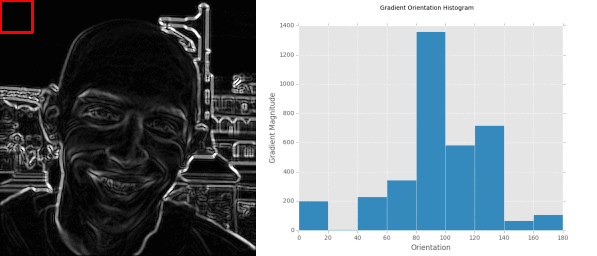

## Image Descriptors
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html

#### Understanding features

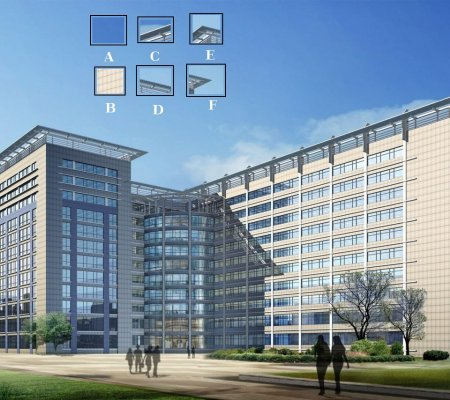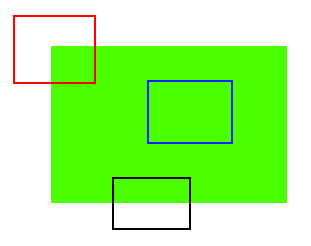


#### Harris corner detection
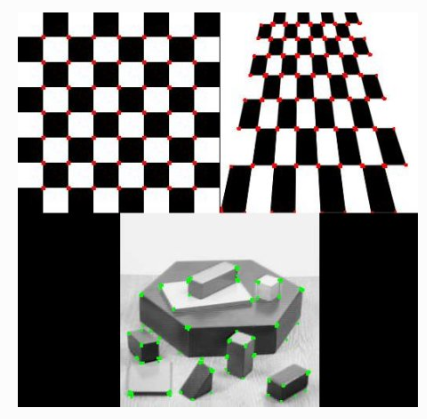


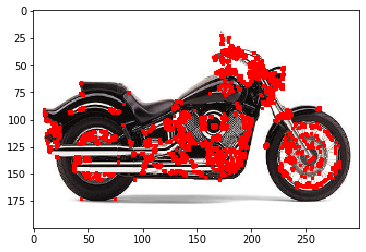

In [10]:
copy = sample_img.copy()
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
copy[dst>0.01*dst.max()]=[0,0,255]
plt.imshow(copy[:, :, [2, 1, 0]])

### Feature Matching
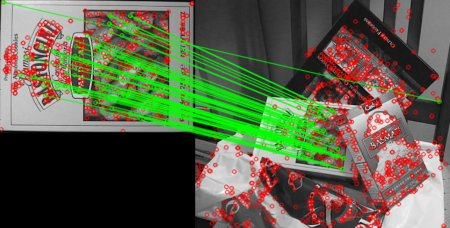

#### Scale Invariant Feature Transform - SIFT
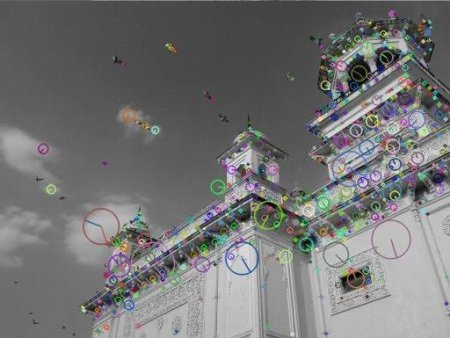

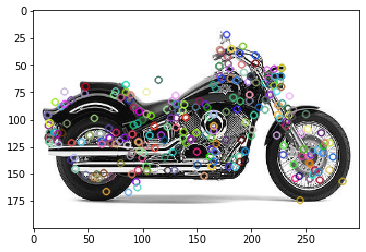

In [11]:
sift = cv2.xfeatures2d.SIFT_create()
kp, des = sift.detectAndCompute(gray,None)

copy = cv2.drawKeypoints(gray,kp, outImage = None)
plt.imshow(copy[:, :, [2, 1, 0]])

In [12]:
des.shape

(278, 128)

## Visual Categorization with Bags of Keypoints 

https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/csurka-eccv-04.pdf
    
###### Stages
1. Feature Extraction
2. Visual vocabulary construction
3. Categorization 

In [13]:
test_data = load_dataset("./Data/Testing/", ["Bikes", "Horses"])

y_train = np.concatenate([np.zeros(len(data[0])), np.ones(len(data[1]))])
y_test = np.concatenate([np.zeros(len(test_data[0])), np.ones(len(test_data[1]))])

x_train = np.concatenate(data)
x_test = np.concatenate(test_data)

#shuffle
p = np.random.permutation(len(x_train))
x_train = x_train[p]
y_train = y_train[p]

In [14]:
sift_keypoints = []

for image in x_train :
    
    image =cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, descriptors = sift.detectAndCompute(image,None)
    sift_keypoints.append(descriptors)


sift_keypoints = np.concatenate(sift_keypoints, axis=0)
kmeans = KMeans(n_clusters = 10).fit(sift_keypoints)

In [15]:
sift_keypoints.shape

(65177, 128)

In [16]:
def calculate_histogram(images, model):

    feature_vectors=[]

    for image in images :

        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        #SIFT extraction
        sift = cv2.xfeatures2d.SIFT_create()
        kp, descriptors = sift.detectAndCompute(image,None)
        #classification of all descriptors in the model
        predict_kmeans = model.predict(descriptors)
        #calculates the histogram
        hist, bin_edges = np.histogram(predict_kmeans, bins = 10)
        #histogram is the feature vector
        feature_vectors.append(hist)

    feature_vectors=np.asarray(feature_vectors)

    return np.array(feature_vectors)

In [17]:
x_feat_train = calculate_histogram(x_train, kmeans)
x_feat_test = calculate_histogram(x_test, kmeans)

In [18]:
clf = svm.LinearSVC(multi_class='ovr')d
clf.fit(x_feat_train, y_train)

/home/soumith/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [19]:
x_test.shape

(15, 200, 300, 3)

In [20]:
y_pred = clf.predictd(x_feat_test)
accuracy_score(y_pred, y_test)

0.8666666666666667

### HOG Classification

In [21]:
def calculate_histogram(images) :
    feats = []
    for image in images :
        H = feature.hog(image, orientations=9, pixels_per_cell=(10, 10), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")
        feats.append(H)
    return np.array(feats)
x_feat_train = calculate_histogram(x_train)
x_feat_test = calculate_histogram(x_test)

In [22]:
clf = svm.LinearSVC(multi_class='ovr')
clf.fit(x_feat_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [23]:
y_pred = clf.predict(x_feat_test)
accuracy_score(y_pred, y_test)

0.7333333333333333

# Deep Learning Approaches

## Auto Encoders
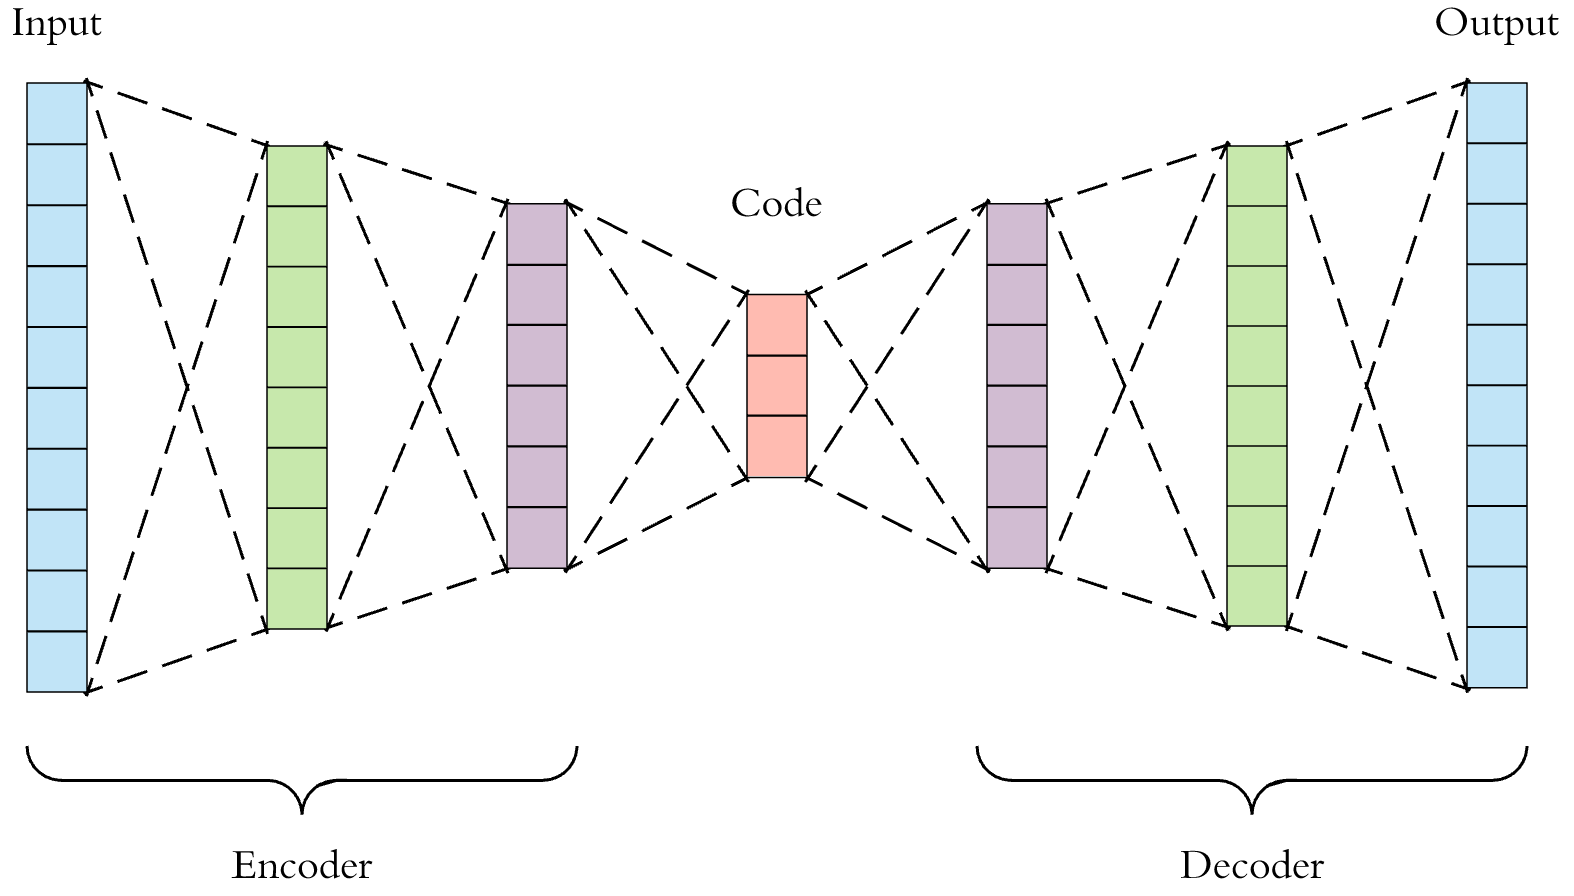

In [24]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32

input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)



Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [25]:
# Deeper model

# input_img = Input(shape=(784,))
# encoded1 = Dense(256, activation='relu')(input_img)
# encoded = Dense(32, activation='relu')(encoded1)
# decoded1 = Dense(256, activation='relu')(encoded)
# decoded = Dense(784, activation='sigmoid')(decoded1)
# autoencoder = Model(input_img, decoded)
# autoencoder.summary()

In [26]:
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [27]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [28]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
sample = x_train[0]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


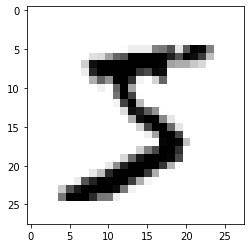

In [29]:
plt.imshow(sample, cmap="binary")

In [30]:
autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 4s 67us/step - loss: 0.3664 - val_loss: 0.2706
Epoch 2/30
60000/60000 [==============================] - 3s 43us/step - loss: 0.2623 - val_loss: 0.2506
Epoch 3/30
60000/60000 [==============================] - 3s 44us/step - loss: 0.2412 - val_loss: 0.2299
Epoch 4/30
60000/60000 [==============================] - 3s 44us/step - loss: 0.2226 - val_loss: 0.2129
Epoch 5/30
60000/60000 [==============================] - 3s 44us/step - loss: 0.2076 - val_loss: 0.2000
Epoch 6/30
60000/60000 [==============================] - 3s 44us/step - loss: 0.1965 - val_loss: 0.1904
Epoch 7/30
60000/60000 [==============================] - 3s 43us/step - loss: 0.1879 - val_loss: 0.1828
Epoch 8/30
60000/60000 [==============================] - 3s 43us/step - loss: 0.1811 - val_loss: 0.1765
Epoch 9/30
60000/60000 [==============================] - 3s 4

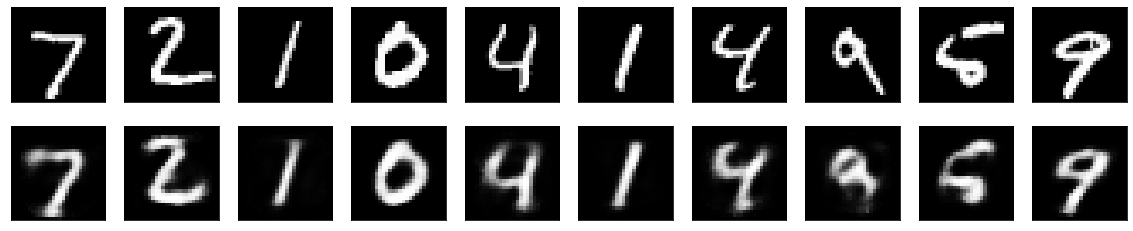

In [31]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [32]:
encoded_imgs.shape

(10000, 32)

Try running for more epochs for better performance. Try deeper models. 
A variation called denoising autoencoders add noise to the input images to imporve encoding performance.
https://keras.io/examples/mnist_denoising_autoencoder/

## Transfer Learning
#### Extracting features from pre trained models - ImageNet


In [33]:
from keras.applications.vgg16 import VGG16
base_model = VGG16(weights='imagenet', pooling = max)
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [34]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

In [35]:
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

image = cv2.resize(sample_img.copy(), (224, 224))

image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

feats = model.predict(image)
print(feats.shape)

(1, 4096)


##### Other imagenet models in keras

Xception
VGG16
VGG19
ResNet50
ResNet101
ResNet152
ResNet50V2
ResNet101V2
ResNet152V2	
InceptionV3
InceptionResNetV2
MobileNet
MobileNetV2	
DenseNet121
DenseNet169
DenseNet201
NASNetMobile
NASNetLarge

https://keras.io/applications/